# Introduction to Machine Learning HW4

----

#### 姓名：王祥任
#### 學號：0616309

----


## Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import urllib3
import copy
import sklearn as sk
import math
import random as rnd
from sklearn import datasets
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf

## plot_confusion_matrix function taken from sklearn sample with some modification
> Reference : HW1 Sample Code

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,        
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Data Loading & Preprocessing


In [3]:
# Import Word2Vec
from gensim.models.word2vec import Word2Vec

# Data Loading
train = pd.read_json('train.json')
test = pd.read_json('test.json')

# Prepare Data for Word2Vec
train_ingredients = [d[0] for d in train.drop(['id', 'cuisine'], axis=1).values.tolist()]
test_ingredients = [d[0] for d in test.drop(['id'], axis=1).values.tolist()]

all_ingredients = []
for d in train_ingredients:
    all_ingredients.append(d)
for d in test_ingredients:
    all_ingredients.append(d)

# Prepare 
model = Word2Vec(all_ingredients, size=300, iter=20, min_count=1, workers=12)


In [4]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,9,1.806670,1.324622,-5.219316,-2.654418,1.423846,1.166988,-4.346165,-2.733656,-0.566392,...,3.408115,0.161286,1.459570,-0.383075,-3.333299,3.580198,5.530595,1.149123,3.530477,-3.577704
1,16,1.859531,-2.299317,-1.430808,-3.861421,-3.550800,0.943516,-0.221625,-1.770864,0.993037,...,-0.105127,5.128944,0.986266,3.777681,-4.115723,1.308469,2.127580,1.162076,6.311267,0.366776
2,18,1.808029,-2.855671,-2.915461,-4.614515,4.217321,1.143293,-1.886797,-7.097530,1.596961,...,3.972655,2.040094,5.651187,-5.441659,1.733393,1.666098,0.366146,0.212050,2.883732,1.006257
3,14,-0.442881,-0.552154,-0.126392,-1.512333,-0.159409,-0.930885,0.737807,-0.597192,-0.525155,...,-0.420255,2.408546,0.171975,0.509000,-1.686296,1.472882,0.196978,-0.592150,-0.684688,0.002597
4,3,1.133888,-0.780472,-5.062939,-2.293795,2.291898,0.498882,-2.604871,-1.045195,-1.586301,...,4.232070,0.376449,0.416396,-0.766050,1.506317,1.344541,1.792807,0.652883,1.374561,0.517894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,1.243297,-5.445845,-4.883620,-5.682850,3.873632,5.830196,1.561378,-4.947379,-4.339639,...,3.950484,-1.941817,3.866997,-2.201448,0.334900,5.045251,2.706714,-2.760298,9.074776,1.066681
29770,19,-0.320236,-6.895783,-3.055070,-3.505912,-1.377970,3.675135,4.729039,-5.151949,-1.685377,...,1.295516,-0.472196,5.439025,-1.134240,-1.449903,1.403686,-1.897989,-0.698219,0.595371,-1.150072
29771,7,5.903119,0.479044,-3.909411,1.204412,-0.909358,5.363714,1.103842,0.013455,-3.119148,...,3.385365,-0.906947,3.108967,-0.338335,2.192324,-0.528772,4.512582,-1.584424,4.809642,3.024534
29772,16,0.691021,-0.608440,-1.912908,-0.802139,-2.492231,-0.015850,1.055206,-0.175837,1.164807,...,-1.250089,3.064157,-1.284632,3.936944,-2.534821,1.457301,1.455909,2.597109,3.206480,-0.463740


## Holdout 7:3

In [5]:
def hold_out(data, classes, model_type='svm', target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    if model_type == 'svm':
        clf = sk.svm.SVC()
        clf.fit(train_x, train_y)
        # Predict
        pred = clf.predict(valid_x)
    elif model_type == 'ann' :
        clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

        clf.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

        clf.fit(train_x, train_y, epochs=50)
        # Predict
        pred = clf.predict(valid_x)
        pred = [np.argmax(d) for d in pred]

    # Display
    cl_labels = np.array(classes)

    print("|-----|-----|-----|-----|-----|")
    print("              %s              " % (model_type))
    print("|-----|-----|-----|-----|-----|")

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

hold_out(train_set, classes, 'svm')
hold_out(train_set, classes, 'ann')

## Without Word2Vec

In [6]:
train = pd.read_json('train.json')

enc = {}
enc_idx = 0

train_set_zp = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    for gre in data[2]:
        if gre in enc.keys():
            tmp.append(enc[gre])
        else:
            enc_idx+=1
            enc[gre] = enc_idx
            tmp.append(enc[gre])
    train_set_zp.append(tmp)
train_set_zp = pd.DataFrame(train_set_zp)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set_zp[0])

classes = le.classes_

train_set_zp[0] = le.transform(train_set_zp[0])
train_set_zp = train_set_zp.fillna(0)
train_set_zp

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,9,1,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,16,12,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,18,22,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,9,34.0,35.0,31.0,36.0,37.0,38.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,30,39.0,40.0,11.0,41.0,42.0,26.0,43.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,26,353.0,24.0,873.0,80.0,65.0,464.0,190.0,1153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29770,19,471,775.0,2820.0,761.0,119.0,951.0,13.0,1916.0,771.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29771,7,191,210.0,50.0,43.0,190.0,168.0,13.0,101.0,626.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29772,16,15,218.0,489.0,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
hold_out(train_set_zp, classes, 'svm')
hold_out(train_set_zp, classes, 'ann')

# Kaggle

In [8]:
train = pd.read_json('train.json')
train_set = []
for data in train.values.tolist():
    tmp = []
    tmp.append(data[1])
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[2]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    train_set.append(tmp)
train_set = pd.DataFrame(train_set)

le = sk.preprocessing.LabelEncoder()
le.fit(train_set[0])

classes = le.classes_

train_set[0] = le.transform(train_set[0])
train_set

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,9,1.806670,1.324622,-5.219316,-2.654418,1.423846,1.166988,-4.346165,-2.733656,-0.566392,...,3.408115,0.161286,1.459570,-0.383075,-3.333299,3.580198,5.530595,1.149123,3.530477,-3.577704
1,16,1.859531,-2.299317,-1.430808,-3.861421,-3.550800,0.943516,-0.221625,-1.770864,0.993037,...,-0.105127,5.128944,0.986266,3.777681,-4.115723,1.308469,2.127580,1.162076,6.311267,0.366776
2,18,1.808029,-2.855671,-2.915461,-4.614515,4.217321,1.143293,-1.886797,-7.097530,1.596961,...,3.972655,2.040094,5.651187,-5.441659,1.733393,1.666098,0.366146,0.212050,2.883732,1.006257
3,14,-0.442881,-0.552154,-0.126392,-1.512333,-0.159409,-0.930885,0.737807,-0.597192,-0.525155,...,-0.420255,2.408546,0.171975,0.509000,-1.686296,1.472882,0.196978,-0.592150,-0.684688,0.002597
4,3,1.133888,-0.780472,-5.062939,-2.293795,2.291898,0.498882,-2.604871,-1.045195,-1.586301,...,4.232070,0.376449,0.416396,-0.766050,1.506317,1.344541,1.792807,0.652883,1.374561,0.517894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29769,11,1.243297,-5.445845,-4.883620,-5.682850,3.873632,5.830196,1.561378,-4.947379,-4.339639,...,3.950484,-1.941817,3.866997,-2.201448,0.334900,5.045251,2.706714,-2.760298,9.074776,1.066681
29770,19,-0.320236,-6.895783,-3.055070,-3.505912,-1.377970,3.675135,4.729039,-5.151949,-1.685377,...,1.295516,-0.472196,5.439025,-1.134240,-1.449903,1.403686,-1.897989,-0.698219,0.595371,-1.150072
29771,7,5.903119,0.479044,-3.909411,1.204412,-0.909358,5.363714,1.103842,0.013455,-3.119148,...,3.385365,-0.906947,3.108967,-0.338335,2.192324,-0.528772,4.512582,-1.584424,4.809642,3.024534
29772,16,0.691021,-0.608440,-1.912908,-0.802139,-2.492231,-0.015850,1.055206,-0.175837,1.164807,...,-1.250089,3.064157,-1.284632,3.936944,-2.534821,1.457301,1.455909,2.597109,3.206480,-0.463740


In [9]:
test = pd.read_json('test.json')
test_set = []
for data in test.values.tolist():
    tmp = []
    gre_vec = np.array([0 for _ in range(300)])
    for gre in data[1]:
        gre_vec = np.add(gre_vec, np.array(model.wv[gre]))
    tmp.extend(gre_vec)
    test_set.append(tmp)
test_set = pd.DataFrame(test_set)
test_set

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,2.777314,-1.936685,-2.667620,-1.670030,0.823164,0.264514,0.307133,-1.126439,-0.513086,-0.014397,...,2.211075,-0.971068,-0.149359,-0.873110,2.162248,-0.815419,-0.815617,-2.202393,-2.383481,-0.828952
1,3.621067,-2.677530,-6.763260,-2.791127,2.303958,5.205305,-1.867176,-1.912400,1.549076,-1.730022,...,6.843252,-2.102432,4.746438,-2.576245,4.803195,0.100056,8.128486,-1.920562,0.650927,-1.049678
2,1.980822,-4.067978,-7.877600,-1.796648,-1.065350,1.422958,1.044917,0.140528,0.878377,-2.468579,...,1.839604,-0.772260,2.026028,-4.291487,4.857389,-2.085694,0.097287,1.364991,-0.032602,-0.197359
3,3.220724,-7.928759,-8.108451,-3.240041,3.083882,-1.207183,-0.773492,2.025321,1.941588,5.108807,...,5.715592,0.777282,3.020095,-3.524070,6.342357,0.912573,-2.384497,-2.689521,-1.282762,0.615178
4,5.163405,-4.282019,-7.917529,-3.777274,3.356104,-1.236606,-2.969414,2.439044,1.972338,2.713163,...,2.470020,2.174722,1.816670,-4.556574,2.230838,-5.679274,-2.756790,2.338817,-0.845348,-2.152471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.852896,4.535460,-1.547112,0.551193,2.420653,2.685963,-1.801268,3.713666,0.351767,-3.642851,...,-1.915310,3.649057,11.548903,0.784171,-3.880433,4.318958,9.604047,0.515394,9.759499,-0.697297
9996,1.088505,-2.785468,-1.695125,-3.542417,0.309215,1.814972,-0.033728,-4.037908,1.262415,0.028000,...,2.488263,0.863033,2.543174,-1.575843,-0.079975,0.000384,0.077640,-0.375819,-1.047266,-0.360910
9997,-0.145061,0.055095,0.754059,-0.634878,0.301490,0.140187,0.045686,-0.614743,0.020265,-0.046728,...,-0.283195,0.918983,0.067592,0.474813,-0.685774,0.957793,1.022269,-1.132471,-0.294111,0.265236
9998,-1.708681,-2.793338,-1.675777,-1.298874,0.503816,-1.420577,0.850313,2.947346,-4.020559,-2.732418,...,-6.039756,1.566778,0.297560,1.814553,-4.547792,4.360574,3.118458,1.928598,9.452193,-1.453207


In [10]:
def kaggle(data, target_name=0):
    # Split Data
    train_y = data[target_name] # Target
    train_x = data.drop(target_name, axis=1) # Attribute

    # train Model
    clf = tf.keras.models.Sequential([
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(300, activation='sigmoid'),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(600, activation='sigmoid'),
            tf.keras.layers.Dense(20, activation='sigmoid')
        ])

    clf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    clf.fit(train_x, train_y, epochs=50)
       

    return clf

clf = kaggle(train_set)

In [11]:
pred = clf.predict(test_set)
pred = [np.argmax(d) for d in pred]

pred_cate = [classes[idx] for idx in pred]
id_list = [data[0] for data in test.values.tolist()]

import csv
with open('pred.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)

    writer.writerow(['Id', 'Category'])

    idx = 0
    for id in id_list:
        writer.writerow([id, pred_cate[idx]])
        idx+=1

    


|-----|-----|-----|-----|-----|
              linear              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.39      0.33      0.36       111
     british       0.35      0.30      0.32       169
cajun_creole       0.71      0.68      0.69       350
     chinese       0.73      0.83      0.77       599
    filipino       0.58      0.56      0.57       186
      french       0.49      0.56      0.52       574
       greek       0.70      0.65      0.68       248
      indian       0.86      0.88      0.87       687
       irish       0.45      0.26      0.33       133
     italian       0.77      0.85      0.81      1779
    jamaican       0.70      0.46      0.55       145
    japanese       0.76      0.67      0.71       357
      korean       0.74      0.63      0.68       196
     mexican       0.87      0.88      0.87      1418
    moroccan       0.78      0.70      0.74       196
     russian       0.56      0.35   

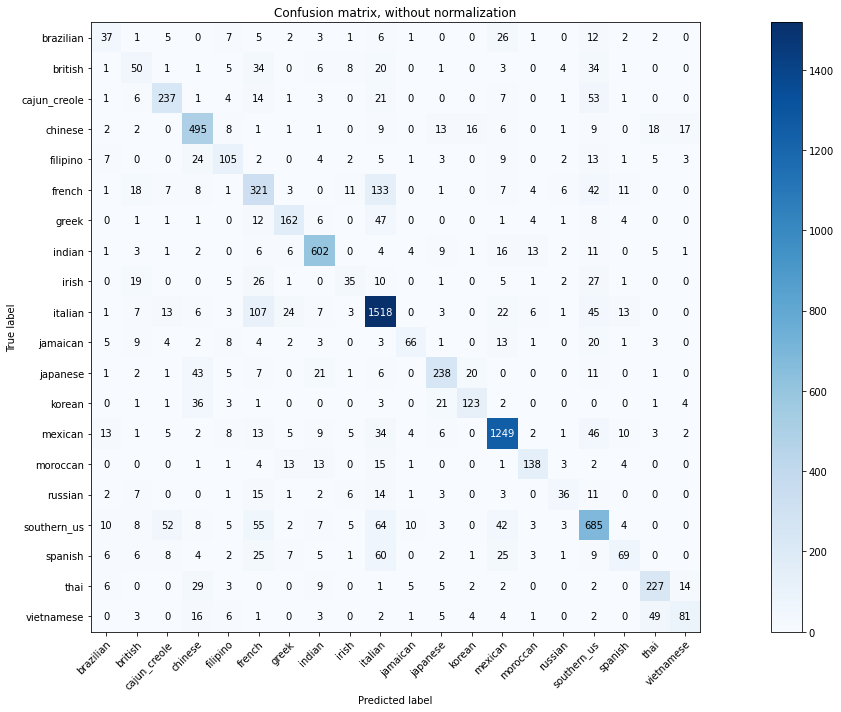

|-----|-----|-----|-----|-----|
              poly              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.69      0.10      0.17       111
     british       0.45      0.11      0.18       169
cajun_creole       0.77      0.52      0.62       350
     chinese       0.71      0.79      0.75       599
    filipino       0.85      0.38      0.53       186
      french       0.58      0.25      0.35       574
       greek       0.80      0.38      0.52       248
      indian       0.89      0.80      0.84       687
       irish       0.36      0.07      0.11       133
     italian       0.49      0.94      0.64      1779
    jamaican       0.83      0.37      0.51       145
    japanese       0.85      0.46      0.60       357
      korean       0.74      0.42      0.53       196
     mexican       0.90      0.81      0.85      1418
    moroccan       0.84      0.58      0.69       196
     russian       0.58      0.07     

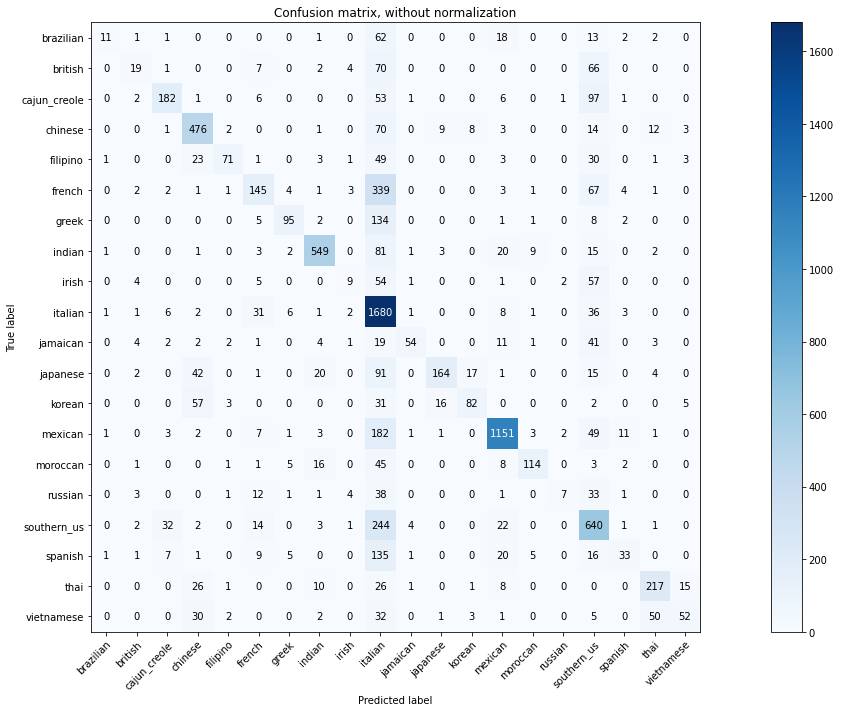

|-----|-----|-----|-----|-----|
              sigmoid              
|-----|-----|-----|-----|-----|
              precision    recall  f1-score   support

   brazilian       0.11      0.02      0.03       111
     british       0.11      0.05      0.07       169
cajun_creole       0.42      0.37      0.39       350
     chinese       0.56      0.70      0.62       599
    filipino       0.35      0.18      0.24       186
      french       0.35      0.29      0.32       574
       greek       0.27      0.29      0.28       248
      indian       0.66      0.70      0.68       687
       irish       0.07      0.07      0.07       133
     italian       0.57      0.78      0.66      1779
    jamaican       0.21      0.05      0.08       145
    japanese       0.50      0.36      0.42       357
      korean       0.43      0.20      0.28       196
     mexican       0.73      0.80      0.76      1418
    moroccan       0.28      0.10      0.14       196
     russian       1.00      0.02  

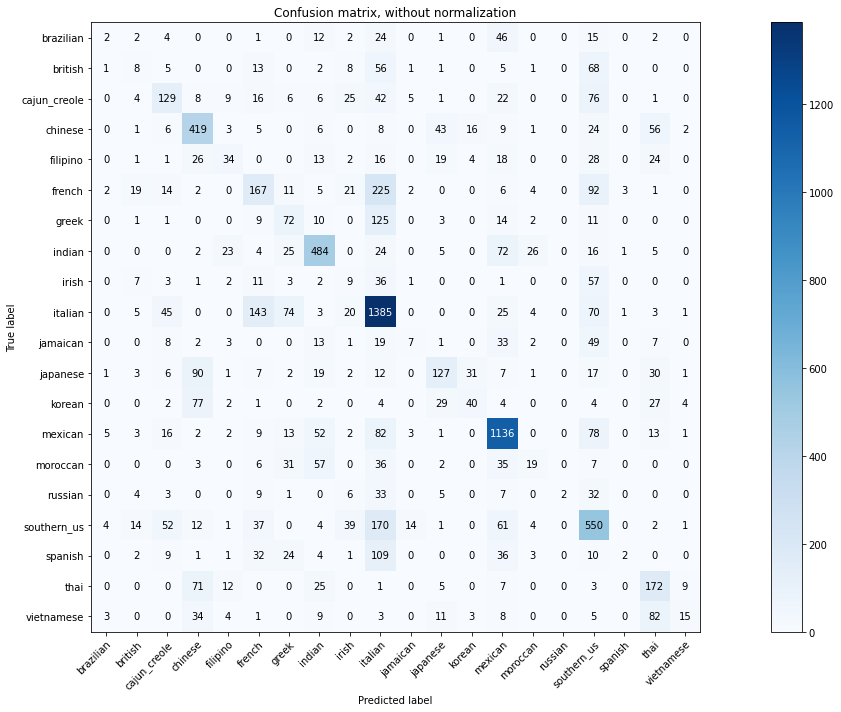

In [12]:
def svm_hold_out(data, classes, kernel_type='rbf', target_name=0, ratio=0.7, random_state=0):
    # Split Data
    y = data[target_name] # Target
    x = data.drop(target_name, axis=1) # Attribute
    train_x, valid_x, train_y, valid_y = train_test_split(x, y, train_size=ratio, random_state=random_state) # ratio = 7:3

    # train Model
    clf = sk.svm.SVC(kernel=kernel_type)
    clf.fit(train_x, train_y)
    # Predict
    pred = clf.predict(valid_x)

    # Display
    cl_labels = np.array(classes)

    print("|-----|-----|-----|-----|-----|")
    print("              %s              " % (kernel_type))
    print("|-----|-----|-----|-----|-----|")

    print(classification_report(valid_y, pred, target_names=cl_labels))
    plot_confusion_matrix(valid_y, pred, classes=cl_labels, cmap=plt.cm.Blues)
    plt.show()

svm_hold_out(train_set, classes, 'linear')
svm_hold_out(train_set, classes, 'poly')
svm_hold_out(train_set, classes, 'sigmoid')
